# Generative Adversarial Networks (GANs)

## Advantages

- Generative rather than discrimitive models.
- Create images, text, music, etc.

## Disadvantages

- Similar to most other deep learning models.

## References

1. Generative Deep Learning, by David Foster.
1. GANs in Action, by Jakub Langr & Vladimir Bok
1. TensorFlow GAN Tutorial: [https://www.tensorflow.org/tutorials/generative/dcgan](https://www.tensorflow.org/tutorials/generative/dcgan)

## The Model



In [1]:
import os
import time
import glob

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import imageio
import PIL
import tensorflow_docs.vis.embed as embed

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

In [5]:
# Randomly shuffle and create batches of train_images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

The generator takes random noise and uses convolutional 2D transpose layers to reshape into an image. Output is in 28x28x1 shape of the `train_images` dataset.

In [6]:
def make_generator_model():
    model = keras.Sequential()

    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(
        1, (5, 5), strides=(2, 2), padding='same', 
        use_bias=False, activation='tanh')
        )
    assert model.output_shape == (None, 28, 28, 1)

    return model

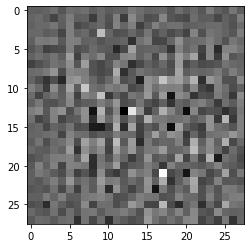

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

## Discriminator

A discriminator is a classification CNN that takes an image and outputs a binary classification value.

In [9]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00060571]], shape=(1, 1), dtype=float32)


In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## Loss Functions

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer Function

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Training Checkpoints

In [16]:
checkpoint_dir = './gan_training_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
    )

## Image Generation

In [17]:
image_prefix = './gan_images'
if not os.path.exists(image_prefix):
    os.mkdir(image_prefix)

In [18]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(image_prefix, f'image_at_epoch_{epoch:04d}.png'))
    plt.close()

## Training

In [19]:
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

In [20]:
# tf.function causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
    train_start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        generate_and_save_images(generator, epoch + 1, seed)

        checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Epoch {epoch + 1} of {epochs}. Run time for epoch is {time.time() - epoch_start} sec.')

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)
    print(f'Completed {epochs} epochs in {time.time() - train_start} sec.')

In [22]:
train(train_dataset, EPOCHS)

Epoch 1 of 50. Run time for epoch is 210.03255486488342 sec.
Epoch 2 of 50. Run time for epoch is 195.79319310188293 sec.
Epoch 3 of 50. Run time for epoch is 195.83997988700867 sec.
Epoch 4 of 50. Run time for epoch is 196.8175859451294 sec.
Epoch 5 of 50. Run time for epoch is 194.22963404655457 sec.
Epoch 6 of 50. Run time for epoch is 197.87206268310547 sec.
Epoch 7 of 50. Run time for epoch is 195.9639503955841 sec.
Epoch 8 of 50. Run time for epoch is 194.4864959716797 sec.
Epoch 9 of 50. Run time for epoch is 195.24386262893677 sec.
Epoch 10 of 50. Run time for epoch is 194.79253888130188 sec.
Epoch 11 of 50. Run time for epoch is 195.90115928649902 sec.
Epoch 12 of 50. Run time for epoch is 198.0157470703125 sec.
Epoch 13 of 50. Run time for epoch is 194.88012409210205 sec.
Epoch 14 of 50. Run time for epoch is 203.6377284526825 sec.
Epoch 15 of 50. Run time for epoch is 234.32813715934753 sec.
Epoch 16 of 50. Run time for epoch is 237.17758440971375 sec.
Epoch 17 of 50. Run ti

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open(os.path.join(image_prefix, f'image_at_epoch_{epoch_no:04d}.png'))

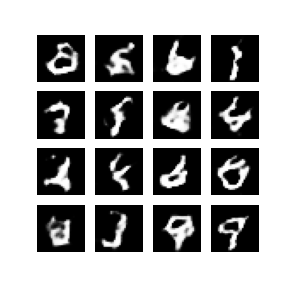

In [25]:
display_image(30)

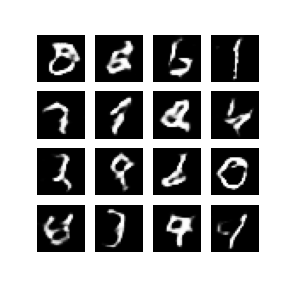

In [26]:
display_image(40)

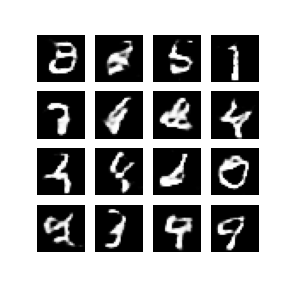

In [27]:
display_image(50)

In [28]:
anim_file = os.path.join(image_prefix, 'dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(image_prefix, 'image*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


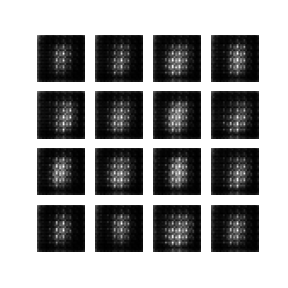

In [29]:
embed.embed_file(anim_file)

In [30]:
model_dir = './gan_models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
gen_model_file = os.path.join(model_dir, f'generator_{EPOCHS:04d}.h5')
disc_model_file = os.path.join(model_dir, f'discriminator_{EPOCHS:04d}.h5')

def save_models(generator, discriminator):
    generator.save(gen_model_file)
    discriminator.save(disc_model_file)

In [31]:
save_models(generator, discriminator)